In [141]:
import numpy as np
import matplotlib.pyplot as plt  # 导入Matplotlib库
from mpl_toolkits.mplot3d import Axes3D

以下为计算成对距离的函数，它的原理是：对于每个点，计算它与其他点的距离，然后取最小的距离作为它的成对距离。这样，每个点都有一个成对距离，然后取所有点的成对距离的平均值作为最终的成对距离。

In [142]:
# 计算成对距离的函数
def pairwise_distances(X):
    dist_matrix = np.sqrt(np.sum((X[:, None] - X) ** 2, axis=2))
    return dist_matrix

In [143]:
# 计算最近邻的索引
def nearest_neighbors(X, k):
    dist_matrix = pairwise_distances(X)

    np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')

    return dist_matrix.argsort(axis=1)[:, 1:k+1]

In [144]:
# 构建邻接矩阵
def construct_adjacency_matrix(X, method, epsilon, n_neighbors):
    if method == 'epsilon':
        dist_matrix = pairwise_distances(X)
        adjacency_matrix = np.where(dist_matrix < epsilon, 1, 0)
        np.fill_diagonal(adjacency_matrix, 0)  # 不连接到自身
        return adjacency_matrix
    elif method == 'k_nearest_neighbors':

        knn_matrix = nearest_neighbors(X, n_neighbors)
        np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',')

        adjacency_matrix = np.zeros((len(X), len(X)))
        for i in range(len(X)):
            for j in knn_matrix[i]:
                adjacency_matrix[i][int(j)] = 1
                adjacency_matrix[int(j)][i] = 1
        np.fill_diagonal(adjacency_matrix, 0)  # 不连接到自身
        return adjacency_matrix

In [145]:
# 计算权重矩阵（热核方法）
def compute_weights(adjacency_matrix, X, t=1.0):
    n_samples = adjacency_matrix.shape[0]
    weights = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j and adjacency_matrix[i][j] == 1:
                distance_squared = np.sum((X[i] - X[j]) ** 2)  # 欧氏距离的平方
                weights[i][j] = np.exp(-distance_squared / t)  # 根据热核方法计算权重
    return weights


In [146]:
# 计算拉普拉斯矩阵
def compute_laplacian_matrix(weights):
    D = np.diag(np.sum(weights, axis=1))
    return D - weights

In [147]:
# 解决广义特征值问题
def solve_generalized_eigenproblem(X, L, D, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.pinv(D) @ L)
    # 选择前 n_components 个特征向量对应的特征值
    indices = np.argsort(eigenvalues)[:n_components]
    return eigenvectors[:, indices]

In [148]:
# 构建映射矩阵
def construct_mapping_matrix(eigenvectors):
    return eigenvectors

In [149]:
# LPP算法
def LPP(X, n_neighbors, n_components, method):
    # Step 1: 构建邻接图
    adjacency_matrix = construct_adjacency_matrix(X, method, epsilon=0.5, n_neighbors=n_neighbors)

    np.savetxt('adjacency_matrix.csv', adjacency_matrix, delimiter=',')

    # Step 2: 选择权重
    weights = compute_weights(adjacency_matrix, X)

    np.savetxt('weights.csv', weights, delimiter=',')

    # Step 3: 计算拉普拉斯矩阵
    laplacian_matrix = compute_laplacian_matrix(weights)

    np.savetxt('laplacian_matrix.csv', laplacian_matrix, delimiter=',')

    # Step 4: 解决广义特征值问题
    embedding = solve_generalized_eigenproblem(X, laplacian_matrix, np.diag(np.sum(weights, axis=1)), n_components)

    np.savetxt('embedding.csv', embedding, delimiter=',')

    # Step 5: 构建映射矩阵
    mapping_matrix = construct_mapping_matrix(embedding)

    np.savetxt('mapping_matrix.csv', mapping_matrix, delimiter=',')
    
    # Step 6: 计算投影矩阵
    mapping_matrix=np.transpose(mapping_matrix)
    return mapping_matrix @ X

In [150]:
# 示例数据
X = np.load('D:/OneDrive - email.szu.edu.cn/Manifold Learning/swiss roll-1000.npy')

np.savetxt('X.csv', X, delimiter=',')

# 将 X 格式化为 (n_samples, n_features)
X_trans = np.transpose(X)

np.savetxt('X_trans.csv', X_trans, delimiter=',')

# 设置参数
n_neighbors = 50
n_components = 2
method = 'k_nearest_neighbors'
# 执行LPP算法
lpp_embeddings = LPP(X_trans, n_neighbors=n_neighbors, n_components=n_components, method=method)

# 保存数据集 lpp_embeddings 到文件

np.savetxt('lpp_embeddings.csv', lpp_embeddings, delimiter=',')

In [151]:
import pandas as pd
csvs = ['X.csv', 'X_trans.csv', 'dist_matrix.csv', 'knn_matrix.csv', 'adjacency_matrix.csv', 'weights.csv', 'laplacian_matrix.csv', 'embedding.csv', 'lpp_embeddings.csv', ]
for csv in csvs:
    df = pd.read_csv(csv, header=None)
    dimension = df.shape
    print(f"File: {csv}, Dimension: {dimension}")

File: X.csv, Dimension: (3, 1000)
File: X_trans.csv, Dimension: (1000, 3)
File: dist_matrix.csv, Dimension: (1000, 1000)
File: knn_matrix.csv, Dimension: (1000, 50)
File: adjacency_matrix.csv, Dimension: (1000, 1000)
File: weights.csv, Dimension: (1000, 1000)
File: laplacian_matrix.csv, Dimension: (1000, 1000)
File: embedding.csv, Dimension: (1000, 2)
File: lpp_embeddings.csv, Dimension: (2, 3)


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 2.

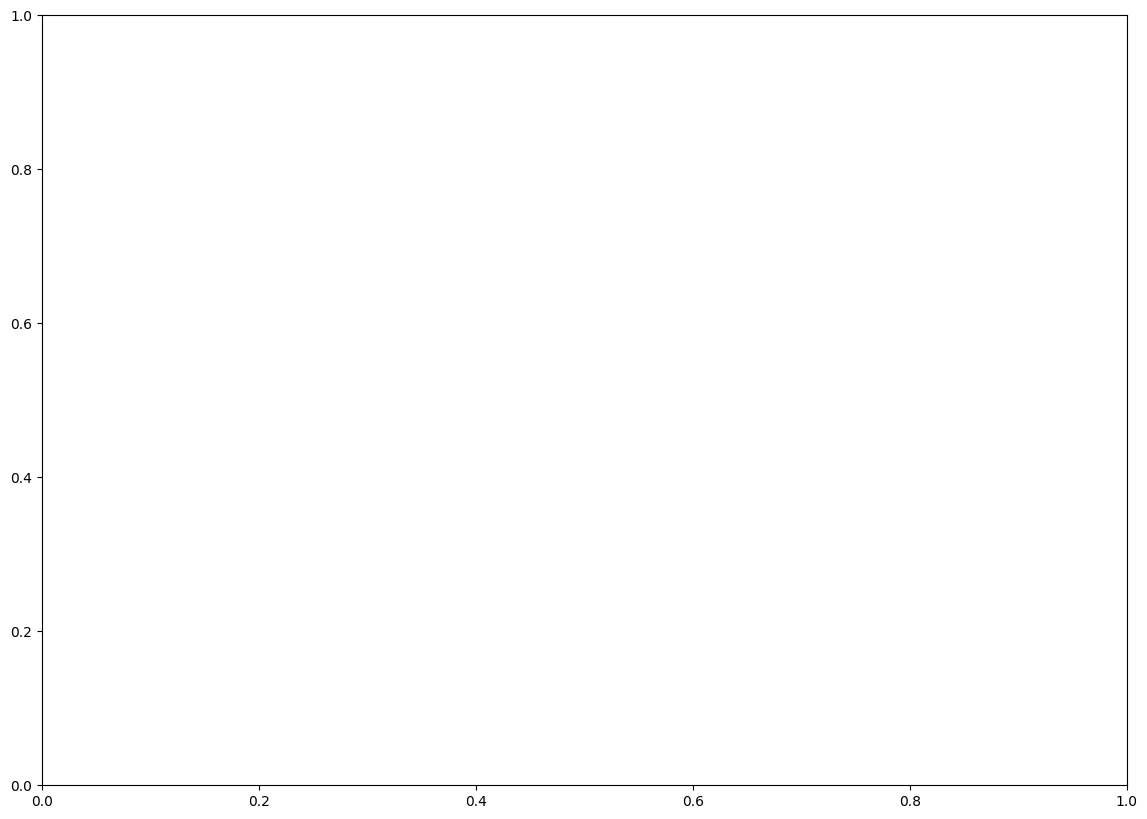

In [152]:
# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((X_trans[:,0]**2+X_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show()